In [133]:
import cortx_community as cc
import cortx_graphing as cg
from github import Github  # https://pygithub.readthedocs.io/
import github
import pickle
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
repos={}
repos['ceph'] =cc.get_repos(None,'ceph','ceph')
repos['minio']=cc.get_repos(None,'minio','minio')
repos['cortx']=cc.get_repos(None,'Seagate','cortx')

Orgs = ('minio','ceph','cortx')
AllTypes=('open_issues','closed_issues','open_pullrequests','closed_pullrequests')

In [27]:
issues={}
for k in repos.keys():
    issues[k]=[]
    for r in repos[k]:
        print("Fetching issues for %s" % r.name)
        for i in r.get_issues(state='all'):
            issues[k].append(i)

Fetching issues for ceph
Fetching issues for ceph-qa-chef
Fetching issues for ceph-client
Fetching issues for ceph-qa-suite
Fetching issues for autobuild-ceph
Fetching issues for ceph-cookbook
Fetching issues for ceph-client-standalone
Fetching issues for ceph-build
Fetching issues for ceph-openstack-tools
Fetching issues for ceph-autotests
Fetching issues for barclamp-ceph
Fetching issues for ceph-tools
Fetching issues for ceph-kdump-copy
Fetching issues for package-ceph-barclamp
Fetching issues for ceph-deploy
Fetching issues for ceph-nagios-plugins
Fetching issues for puppet-ceph
Fetching issues for ceph-ansible
Fetching issues for ceph-kmod-rpm
Fetching issues for cephfs-hadoop
Fetching issues for ceph-erasure-code-corpus
Fetching issues for ceph-object-corpus
Fetching issues for ceph-container
Fetching issues for ceph-devstack
Fetching issues for git.ceph.com
Fetching issues for ceph-cm-ansible
Fetching issues for ceph-installer
Fetching issues for ceph-ci
Fetching issues for ceph

In [16]:
print(c)

[Repository(full_name="Seagate/cortx-monitor"), Repository(full_name="Seagate/cortx"), Repository(full_name="Seagate/cortx-s3server"), Repository(full_name="Seagate/cortx-experiments"), Repository(full_name="Seagate/cortx-posix"), Repository(full_name="Seagate/cortx-py-utils"), Repository(full_name="Seagate/cortx-prvsnr"), Repository(full_name="Seagate/cortx-re"), Repository(full_name="Seagate/cortx-ha"), Repository(full_name="Seagate/cortx-hare"), Repository(full_name="Seagate/cortx-management-portal"), Repository(full_name="Seagate/cortx-manager"), Repository(full_name="Seagate/cortx-utils"), Repository(full_name="Seagate/cortx-fs"), Repository(full_name="Seagate/cortx-nsal"), Repository(full_name="Seagate/cortx-dsal"), Repository(full_name="Seagate/cortx-fs-ganesha"), Repository(full_name="Seagate/cortx-motr-galois"), Repository(full_name="Seagate/cortx-motr"), Repository(full_name="Seagate/cortx-motr-apps"), Repository(full_name="Seagate/cortx-mio"), Repository(full_name="Seagate/c

In [206]:
# initialize the stats
gh = Github(os.environ.get('GH_OATH'))
cc.avoid_rate_limiting(gh,10,True)

def get_stats_structure():
    stats = {}
    #for org in ('ceph','minio','cortx'):
    # just clear the ceph stats since it crashed after 60K out of 65K
    for org in Orgs:
        stats[org] = {}
        for Type in AllTypes:
            stats[org][Type] = []
            for Type in ('issues','pullrequests'):
                stats[org]['%s_%s' % (state,Type)] = []
    return(stats)

Rate limit seems OK.  4993 remaining; reset in 2260


In [74]:
def get_response_latency(issue,issue_creation):
    try:
        first_comment = i.get_comments()[0]
        return (first_comment.created_at - birth).total_seconds()
    except IndexError:
        return None

In [103]:
# this one queries information about each issue: age, response latency, status
# so there are four types of issues
# open pull requests
# closed pull requests
# open issues
# closed issues
org='ceph'
for i in issues[org]:
    cc.avoid_rate_limiting(gh,10,False)
    state=i.state
    birth=i.created_at
    latency = get_response_latency(i,birth)
    
    if i.pull_request is None:
        Type="issues"
    else:
        Type="pullrequests"
    
    if state == 'open':
        full_type = 'open_%s' % Type
        age_in_seconds = (datetime.utcnow() - birth).total_seconds()
    else:
        full_type = 'closed_%s' % Type
        try:
            age_in_seconds = (i.closed_at - birth).total_seconds()
        except TypeError:
            age_in_seconds = None
            
    stats[org][full_type].append(
        {'birth' : birth, 'age' : age_in_seconds, 'latency' : latency})
    if (len(stats[org][full_type]) % 100 == 0):
        print("Collected %d of %s" % 
              (len(stats[org][full_type]),full_type))


KeyError: 'ceph'

In [118]:
# just some debugging info
for k,v in issues.items():
    print(k,": ",len(v))
#print(stats['ceph'])

for org in stats.keys():
    L=0
    for k in stats[org].keys():
        l = len(stats[org][k])
        L += l
        print(k,org,l)
    print(org, L)
#print(stats['cortx']['open_issues'][132])

open_issues ceph 261
open_pullrequests ceph 947
closed_issues ceph 2347
closed_pullrequests ceph 57722
ceph 61277
open_issues minio 107
open_pullrequests minio 54
closed_issues minio 16057
closed_pullrequests minio 23774
minio 39992
open_issues cortx 134
open_pullrequests cortx 311
closed_issues cortx 2104
closed_pullrequests cortx 12422
cortx 14971


In [224]:
def average_days(List,field):
    total_age = 0
    count = len(List)
    for i in List:
        try:
            total_age += (i[field]/86400)
        except TypeError:
            count -= 1 # somehow we don't have data; just ignore
    return total_age / len(List)

def normalize(Dict,Key,Value,Index):
    Dict[Key][Index] /= Value

def get_dataframe(stats):
    bars = [("%s_age" % x,"%s_lat" % x) for x in AllTypes]
    #print(bars)
    panda_data = {'minio' : [], 'ceph' : [], 'cortx' : []}
    bars = [item.replace('_',' ').title() for t in bars for item in t]
    #print(bars)

    # get the averages for each of the types
    for Type in AllTypes:
        for org in Orgs:
            ave_age = average_days(stats[org][Type],'age')
            panda_data[org].append(ave_age)
            ave_lat = average_days(stats[org][Type],'latency')
            panda_data[org].append(ave_lat)
            #print("Ave age of %s in %s is %.2f days" % (Type,org,ave_age/86400))
            #print("Ave latency of %s in %s is %.2f days" % (Type,org,ave_lat/86400))
    
    # print before we normalize
    panda_data['bars'] = bars
    df = pd.DataFrame(panda_data)
    print(df)
    
    # now let's normalize the data
    for i in range(len(panda_data['minio'])):
        minimum = min(panda_data['minio'][i],panda_data['ceph'][i],panda_data['cortx'][i])
        #print(minimum)
        for o in Orgs:
            normalize(panda_data,o,minimum,i)
    
    #panda_data['bars'] = bars
    df = pd.DataFrame(panda_data)
    print(df)
    return df
    

In [226]:
def make_graph(stats,title):
    df = get_dataframe(stats)

    #print(df)
    ax = df.plot.barh(x='bars', y=['ceph','minio','cortx'], rot=0,title=title)
    #ax1 = plt.axes()
    x_axis = ax.axes.get_xaxis()
    x_axis.set_label_text("Normalized Value (Lower is Better)")
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text(None)
    plt.show()
#df.plot(x = ['bars'], y= ['ceph','minio','cortx'], kind = 'bar')

        minio         ceph       cortx                     bars
0  574.991947  1091.423181  244.582877          Open Issues Age
1    3.322433    25.762560   16.888074          Open Issues Lat
2   34.934166   140.861678   65.060154        Closed Issues Age
3   28.559171    33.032444    8.589262        Closed Issues Lat
4  403.026807   336.422545  140.267249    Open Pullrequests Age
5   15.655865    17.128324    2.465162    Open Pullrequests Lat
6    5.851502    24.000239    7.222216  Closed Pullrequests Age
7    1.549934     5.038534    1.480921  Closed Pullrequests Lat
      minio      ceph     cortx                     bars
0  2.350908  4.462386  1.000000          Open Issues Age
1  1.000000  7.754124  5.083044          Open Issues Lat
2  1.000000  4.032204  1.862365        Closed Issues Age
3  3.324986  3.845784  1.000000        Closed Issues Lat
4  2.873278  2.398440  1.000000    Open Pullrequests Age
5  6.350847  6.948155  1.000000    Open Pullrequests Lat
6  1.000000  4.101552  1.

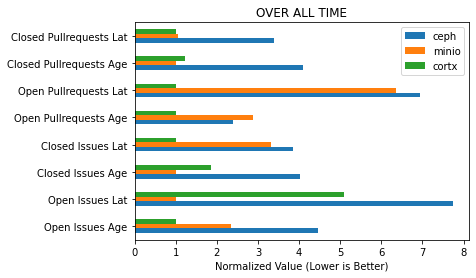

       minio       ceph      cortx                     bars
0  54.016310  65.749477  48.876655          Open Issues Age
1   2.786022   3.382744   1.366022          Open Issues Lat
2   3.717805  11.319465  18.205133        Closed Issues Age
3   1.276787   2.156689   1.485435        Closed Issues Lat
4  28.297497  59.077419  46.867272    Open Pullrequests Age
5  17.488693   4.473975   2.325719    Open Pullrequests Lat
6   2.745221  12.943111   5.233463  Closed Pullrequests Age
7   1.013911   2.958544   1.058766  Closed Pullrequests Lat
      minio      ceph     cortx                     bars
0  1.105156  1.345212  1.000000          Open Issues Age
1  2.039515  2.476347  1.000000          Open Issues Lat
2  1.000000  3.044663  4.896742        Closed Issues Age
3  1.000000  1.689153  1.163417        Closed Issues Lat
4  1.000000  2.087726  1.656234    Open Pullrequests Age
5  7.519692  1.923695  1.000000    Open Pullrequests Lat
6  1.000000  4.714779  1.906390  Closed Pullrequests Age
7  1

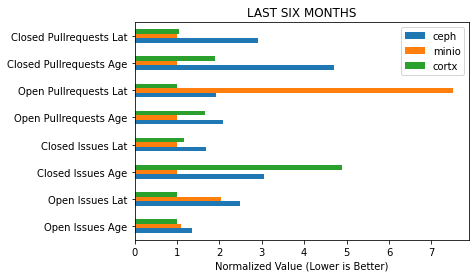

In [227]:
make_graph(stats,"OVER ALL TIME")

def within(issue,months):
    age = (datetime.utcnow() - issue['birth']).total_seconds()
    return age < 6*30*86400
    print(age)

# now let's make a copy of the stats but only for things opened within last six months
recent_stats = get_stats_structure()
for Type in AllTypes:
    for org in Orgs:
        for i in stats[org][Type]:
            if within(i,6):
                recent_stats[org][Type].append(i)
make_graph(recent_stats, "LAST SIX MONTHS")

In [114]:
#with open('issues_stats.pickle', 'ab') as pfile:
#    pickle.dump(stats, pfile)  

with open('issues_stats.pickle', 'rb') as pfile:
    stats=pickle.load(pfile)